# **Variational Auto-Encoder**

Reference: Diederik P. Kingma and Max Welling, “Auto-Encoding Variational Bayes,” arXiv preprint arXiv:1312.6114, 2013.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from functools import reduce

# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# Image directory (Write proper location!)
dir_image = '/content/gdrive/My Drive/Colab Notebooks/딥러닝과제1'

Mounted at /content/gdrive


###**Set training parameters**

In [ ]:
# Parameters
learning_rate = 1e-3
training_epochs = 10
batch_size = 32
display_step = 10

###**Load MNIST data**
Set train & test data

In [ ]:
# Load and prepare the MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(x_train,y_train), (x_test,y_test) = fashion_mnist.load_data()


# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

# Batch datasets
train_data = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(60000)
    .batch(batch_size)
)
test_data = (
    tf.data.Dataset.from_tensor_slices(x_test)
    .shuffle(10000)
    .batch(batch_size)
)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
dim_x = np.shape(x_train)[1:]
dim_x_prod = reduce( (lambda x, y: x * y), dim_x)

###**Set model**


In [ ]:
class VAE(keras.Model):
  """ A basic vae class for tensorflow
  Extends:
    tf.keras.Model
  """
  def __init__(self, **kwargs):
    super(VAE, self).__init__()
    self.__dict__.update(kwargs)

    # Set network
    self.enc_nn = keras.Sequential(self.enc_desc)
    self.dec_nn = keras.Sequential(self.dec_desc)

  def encode(self, x):
    mu, log_sigma = tf.split(self.enc_nn(x), num_or_size_splits=2, axis=1)
    sigma = keras.backend.exp(log_sigma)
    return mu, log_sigma, sigma

  def decode(self, z):
    return self.dec_nn(z)

  def reparam(self, mu, sigma):
    """ Reparameterize. """
    eps = tf.random.normal(shape=mu.shape)
    return mu + eps * sigma

  def reconstruct(self, x):
    mu, _, _ = self.encode(x)
    return self.decode(mu)

  @tf.function
  def compute_loss(self, x):
    mu, log_sigma, sigma = self.encode(x)
    z = self.reparam(mu, sigma)
    x_recon = self.decode(z)
    
    # Compute KL-divergence
    _loss_latent = (-1/2) * (
        self.dim_z + tf.reduce_sum(log_sigma, axis=-1, keepdims=True) \
        - tf.reduce_sum(sigma, axis=-1, keepdims=True) \
        - tf.reduce_sum(mu**2, axis=-1, keepdims=True)
        )
    loss_latent = tf.reduce_mean(_loss_latent)

    # Compute reconstruction loss
    x_r = keras.backend.reshape(x, [-1, self.dim_x_prod])
    x_recon_r = keras.backend.reshape(x_recon, [-1, self.dim_x_prod])
    if self.loss_type == "l2":
      diffsq_x = tf.math.square(x - x_recon)
      _loss_recon = tf.reduce_sum(diffsq_x, axis=-1, keepdims=True)
    else:
      _tmp0 = x_r*keras.backend.log(x_recon_r + 1e-6)
      _tmp1 = (1-x_r)*keras.backend.log(1 - x_recon_r + 1e-6)
      bce = -(_tmp0 + _tmp1)
      _loss_recon = tf.reduce_sum(bce, axis=-1, keepdims=True)
    loss_recon = tf.reduce_mean(_loss_recon)

    return loss_latent, loss_recon

  def compute_gradients(self, x):
    with tf.GradientTape() as tape:
        loss_latent, loss_recon = self.compute_loss(x)
        loss_sum = loss_latent + loss_recon
    cg = tape.gradient(loss_sum, self.enc_nn.trainable_variables + 
                       self.dec_nn.trainable_variables)
    return cg, loss_latent, loss_recon
  
  @tf.function
  def train(self, x):
    """ Trains model. """
    cg, loss_latent, loss_recon = self.compute_gradients(x)
    self.optimizer.apply_gradients(zip(cg, self.enc_nn.trainable_variables + 
                                       self.dec_nn.trainable_variables))
    return loss_latent, loss_recon

In [ ]:
dim_z = 2

enc_desc = [keras.layers.InputLayer(input_shape=dim_x, dtype=tf.float32),
            keras.layers.Flatten(),
            keras.layers.Dense(units = 256, activation="relu"),
            keras.layers.Dense(units = 256, activation="relu"),
            keras.layers.Dense(units=dim_z*2)]

dec_desc = [keras.layers.Dense(units = 256, activation="relu"),
            keras.layers.Dense(units = 256, activation="relu"),
            keras.layers.Dense(units = dim_x_prod, activation="sigmoid"),
            keras.layers.Reshape(target_shape=dim_x)]

# Set loss_type ("l2": l2-loss or "ce": cross-entropy)
loss_type = "ce"

# Set optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
vae = VAE(dim_x=dim_x, dim_z=dim_z, dim_x_prod=dim_x_prod, 
          enc_desc=enc_desc, dec_desc=dec_desc, 
          loss_type=loss_type, optimizer=optimizer)

### Train model

In [ ]:
# Test-data for plot
test_data_plot = next(iter(test_data))

import matplotlib.pyplot as plt

def plot_train(model, x, nex=6, zm=2, epoch=0):
  x_recon = model.reconstruct(x)
  x_sample = model.decode(tf.random.normal(shape=(batch_size, dim_z)))
  
  fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
  
  for axi, (dat, lab) in enumerate(zip([x, x_recon, x_sample],
                                       ["data", "data_recon", "data_sample"],)):
    for ex in range(nex):
      axs[axi, ex].matshow(
          dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
          )
      axs[axi, ex].axes.get_xaxis().set_ticks([])
      axs[axi, ex].axes.get_yaxis().set_ticks([])
      axs[axi, 0].set_ylabel(lab)

  plt.show()
  
  # Save fig
  figname2save = '{:s}/vae_z{:d}_{:s}_e{:d}.png'.format(dir_image,dim_z,
                                                        loss_type,epoch)
  fig.savefig(figname2save)

  plt.close()

In [ ]:
# Select metrics to measure the loss of the model
train_loss_latent = keras.metrics.Mean(name='train_loss_latent')
train_loss_recon = keras.metrics.Mean(name='train_loss_recon')
test_loss_latent = keras.metrics.Mean(name='train_loss_latent')
test_loss_recon = keras.metrics.Mean(name='train_loss_recon')

Epoch 1, Train-Loss: [3.6469,281.0528], Test-Loss: [3.4770,264.2355]


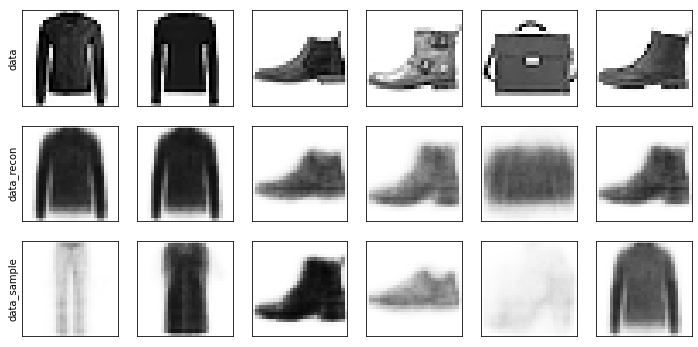

Epoch 2, Train-Loss: [3.4558,260.2139], Test-Loss: [3.4314,259.3948]
Epoch 3, Train-Loss: [3.4207,256.6728], Test-Loss: [3.4104,258.4895]
Epoch 4, Train-Loss: [3.4352,254.9294], Test-Loss: [3.4771,255.2821]
Epoch 5, Train-Loss: [3.4496,253.5588], Test-Loss: [3.4256,254.5138]
Epoch 6, Train-Loss: [3.4822,252.6215], Test-Loss: [3.4178,253.9045]
Epoch 7, Train-Loss: [3.5051,252.4049], Test-Loss: [3.5738,253.1735]
Epoch 8, Train-Loss: [3.5261,251.5812], Test-Loss: [3.5540,253.0054]
Epoch 9, Train-Loss: [3.5484,250.8929], Test-Loss: [3.5058,252.0746]
Epoch 10, Train-Loss: [3.5448,250.8897], Test-Loss: [3.4232,251.9057]


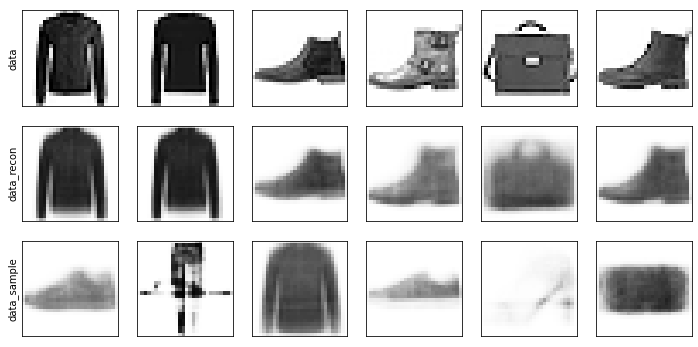

In [ ]:
# Run training for the given number of steps.
for epoch in range(training_epochs):
  for x_batch in train_data:
    loss_latent, loss_recon = vae.train(x_batch)
    train_loss_latent(loss_latent)
    train_loss_recon(loss_recon)

  for x_batch_t in test_data:
    loss_latent_t, loss_recon_t = vae.compute_loss(x_batch_t)
    test_loss_latent(loss_latent_t)
    test_loss_recon(loss_recon_t)

  template = 'Epoch {:d}, Train-Loss: [{:2.4f},{:2.4f}], Test-Loss: [{:2.4f},{:2.4f}]'
  print(template.format(epoch+1, train_loss_latent.result(),
                        train_loss_recon.result(), test_loss_latent.result(),
                        test_loss_recon.result()))

  if epoch % display_step == 0 or epoch == (training_epochs-1):  
    plot_train(vae, test_data_plot, epoch=epoch+1)

  # Reset the metrics for the next epoch
  train_loss_latent.reset_states()
  train_loss_recon.reset_states()
  test_loss_latent.reset_states()
  test_loss_recon.reset_states()

### Plot grid in 2D latent space

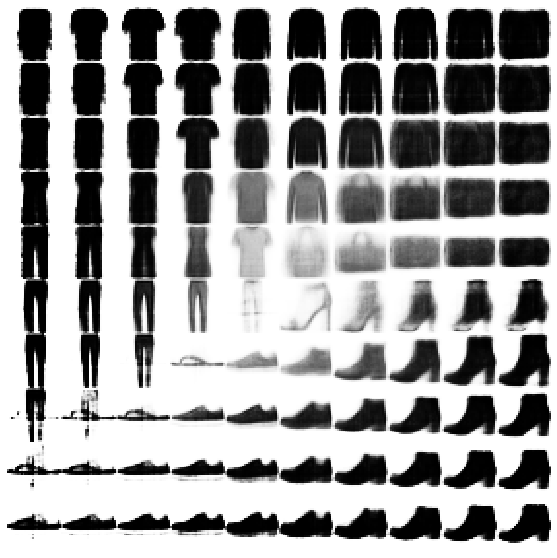

In [ ]:
# Sample from grid
nx = ny = 10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = vae.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# Fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')

# Save fig
figname2save = '{:s}/vae_z{:d}_{:s}_grid.png'.format(dir_image,dim_z,loss_type)
fig.savefig(figname2save)